# AI A3
Written by Babak Hosseini Mohtasham 810101408\
Buidling a 0-9 digits audio recognition ai model using the HMM.

In [892]:
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from sklearn.cluster import KMeans,DBSCAN
from sklearn.preprocessing import Normalizer
import os
import numpy as np
import cv2
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from pandas import read_csv
from sklearn.metrics import homogeneity_score,silhouette_score
np.random.seed(0)

In [893]:
PATH='flower_images'
TARGET_SIZE = (256, 256, 3)

## Preprocess and Feature extraction

In [894]:
def load_normal_images(path, target_size):
    images = []
    files = sorted(os.listdir(path))
    for filename in files:
        file_path = os.path.join(path, filename)
        if file_path.endswith('.png'):
            image = cv2.imread(file_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            images.append(image)
    return images

In [895]:
def load_preprocessed_images(path, target_size):
    images = []
    files = sorted(os.listdir(path))
    for filename in files:
        file_path = os.path.join(path, filename)
        if file_path.endswith('.png'):
            image = load_img(file_path, target_size=target_size)
            image=img_to_array(image)
            image = preprocess_input(image)
            images.append(image)
    return images

In [896]:
csvFile = read_csv(PATH+'/flower_labels.csv')
labels = csvFile['label'].to_numpy()

In [897]:
np.unique(labels, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([21, 20, 19, 22, 21, 25, 23, 15, 26, 18]))

In [898]:
normal_images=load_normal_images(PATH, TARGET_SIZE)
flower_images = np.array(load_preprocessed_images(PATH, TARGET_SIZE))
flower_images.shape

(210, 256, 256, 3)

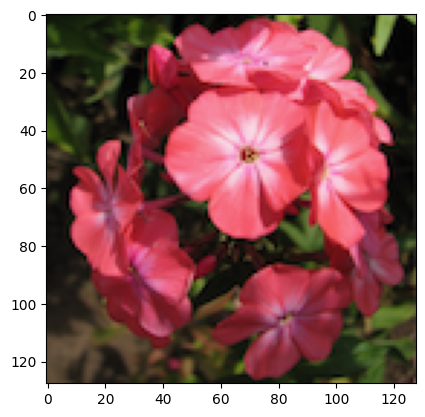

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


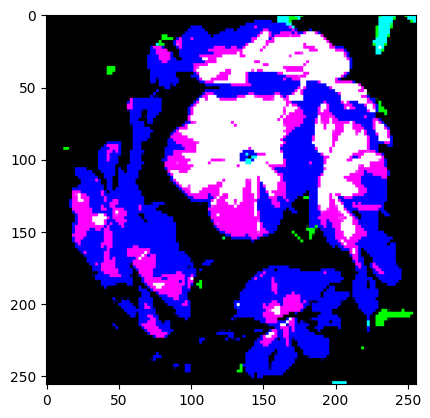

In [899]:
plt.imshow(normal_images[0])
plt.show()
plt.imshow(flower_images[0])
plt.show()

1. 
    Extracting features from images serves several purposes in image clustering:
* `Dimensionality Reduction`: Images typically have high-dimensional pixel data, especially if they're high-resolution. Extracting features helps reduce the dimensionality of the data, making it more manageable and efficient to work with.
* `Feature Representation`: Features extracted from images capture more abstract and meaningful information compared to raw pixel values. For example, features might represent edges, textures, shapes, or color distributions, which can be more informative for clustering than individual pixel values.
* `Enhanced Clustering Performance`: By using features that capture the essence of the image content, clustering algorithms can perform better compared to using raw pixel values. Features can help distinguish between different image categories or concepts more effectively.
* `Robustness to Variations`: Features extracted from images are often more robust to variations in lighting conditions, scale, orientation, and other factors compared to raw pixel values. This robustness improves the generalization ability of clustering algorithms.
* `Interpretability`: Features can sometimes provide more interpretable results compared to using raw pixel values. For example, if certain features correspond to specific visual patterns or objects, it's easier to understand the clusters produced by the algorithm.\
**In conclusion** I've used pixels in another cell to demonstrate that using just pixels usually doesn't give very good results. The reason is just using pixels the models may not be able to distinuguish between images that well and some unnecessary data like the background pixels are used as data training which aren't needed. Furthermore, the noise in images is trained with other pixels and that may not be good.\
To test how would our model perform with pixels as train data I've added the third features which are just pixels and from the pca we can see that the imcages are not separated well enough so the models can't cluster very well.

2.
* `Convolutional Neural Networks(CNN)`: CNNs are generally the preferred choice for feature extraction from images because CNNs are specifically designed for processing color images and perform more complex tasks such as image classification, object detection, or segmentation where it can extract complex and descriptive features with any variations such as lighting conditions, scale, and other factors in the image. It is useful in situations where you want to have high accuracy after processing your images, thus making it the most efficient way.
* `Gray-scale features`: It is useful in situations where color information is not relevant or important for the task at hand. Some of the examples being:
-> Image similarity: Evaluating similarity of 2 images
-> Text Recognition(OCR): Reading text from an image
-> Edge Detection: Detecting boundaries or edges in an image
-> Medical Imaging: Analyze grayscale medical images such as X-rays, CT scans, and MRIs, used to identify tumors or blood vessels in the image.
-> Facial Recognition: Extracting information about the texture of the face, which can be useful for identifying individuals.
* `Mean pixel values of channels`: It is a very basic image feature extraction technique where we calculate the mean intensity of each color channel (red, green, and blue) in an image. This approach can be useful in situations where the goal is to perform a simple image processing operation or to obtain a basic representation of the image such as thumbnail creation, image compression and resizing. However, mean pixel value of channels is generally not a suitable technique for more complex tasks such as image classification, object detection, or segmentation. This is because mean pixel value of channels does not take into account the spatial relationship between the pixels in the image, and it does not consider the relationship between different channels.

In [900]:
model = VGG16(include_top=False, input_shape=TARGET_SIZE)

3. I've tested different preprocessing functions and this one gave the best results when using the library for k means. Using the pca algorithm as features gave better results with library k-means a reason for it may be due to **curse of dimensionality**. In machine learning problems that involve learning a "state-of-nature" from a finite number of data samples in a high-dimensional feature space with each feature having a range of possible values, typically an enormous amount of training data is required to ensure that there are several samples with each combination of values. In an abstract sense, as the number of features or dimensions grows, the amount of data we need to generalize accurately grows exponentially. A typical rule of thumb is that there should be at least 5 training examples for each dimension in the representation. Using the salar functions of skleanr library may give better results because k-means clustering uses distance metrics, such as Euclidean distance, to assign data points to clusters. If the features have different scales or units, the distance calculation can be distorted and biased towards the features with larger values. To avoid this, we can use standardization or normalization to transform the features to have similar ranges and distributions.

In [901]:
features = model.predict((flower_images))
features = features.reshape(features.shape[0], -1)
pca = PCA(n_components=2)
data_pca = pca.fit_transform(features)
features2=np.tanh(data_pca)
features = Normalizer().fit_transform(features)
pca = PCA(n_components=2)
data_pca = pca.fit_transform(features)
features1=data_pca

7/7 [==============================] - 29s 4s/step


In [902]:
def plot_features(features, labels,predictions=None):
    pca = PCA(n_components=2)
    features = pca.fit_transform(features)
    plt.subplot(1,2,1)
    plt.title("True Labels")
    plt.scatter(features[:, 0], features[:, 1], c=labels, cmap='tab10')
    if predictions is None:
        plt.show()
        return
    plt.subplot(1,2,2)
    plt.title("Predicted Labels")
    plt.scatter(features[:, 0], features[:, 1], c=predictions, cmap='tab10')
    plt.show()

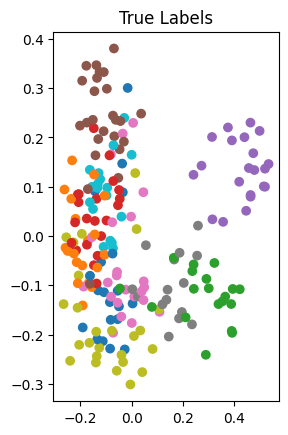

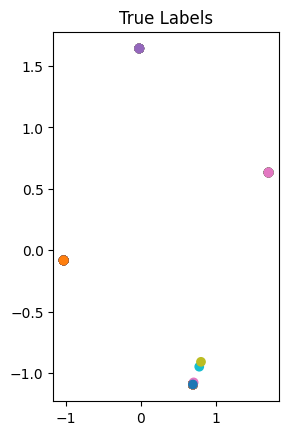

In [903]:
plot_features(features1,labels)
plot_features(features2, labels)

4.
<figure class="table">
<table>
<tbody>
<tr>
<th><strong>S.No.</strong></th>
<th><strong>K-means Clustering</strong></th>
<th><strong>DBScan Clustering</strong></th>
</tr>
<tr>
<th><strong>1.</strong></th>
<th>Clusters formed are more or less spherical or convex in shape and must have same feature size.</th>
<th>Clusters formed are arbitrary in shape and may not have same feature size.</th>
</tr>
<tr>
<th><strong>2.</strong></th>
<th>K-means clustering is sensitive to the number of clusters specified.</th>
<th>Number of clusters need not be specified.</th>
</tr>
<tr>
<th><strong>3.</strong></th>
<th>K-means Clustering is more efficient for large datasets.</th>
<th>DBSCan Clustering can not efficiently handle high dimensional datasets.</th>
</tr>
<tr>
<th><strong>4.</strong></th>
<th>K-means Clustering does not work well with outliers and noisy datasets.</th>
<th>DBScan clustering efficiently handles outliers and noisy datasets.</th>
</tr>
<tr>
<th><strong>5.&nbsp;</strong></th>
<th>In the domain of anomaly detection, this algorithm causes problems as anomalous points will be assigned to the same cluster as “normal” data points.</th>
<th>DBScan algorithm, on the other hand, locates regions of high density that are separated from one another by regions of low density.</th>
</tr>
<tr>
<th><strong>6.</strong></th>
<th>It requires one parameter : Number of clusters (<strong>K</strong>)</th>
<th>
<p>It requires two parameters : Radius(<strong>R</strong>) and Minimum Points(<strong>M</strong>)</p>
<p>R determines a chosen radius such that if it includes enough points within it, it is a dense area.</p>
<p>M determines the minimum number of data points required in a neighborhood to be defined as a cluster.</p>
</th>
</tr>
<tr>
<th><strong>7.</strong></th>
<th>Varying densities of the data points doesn’t affect K-means clustering algorithm.</th>
<th>DBScan clustering does not work very well for sparse datasets or for data points with varying density.</th>
</tr>
</tbody>
</table>
</figure>

# K Means Implemenatation

In [904]:
K=10

In [905]:
def K_Means(features, k):
    i_means=np.random.randint(0,features.shape[0],size=k)
    means=features[i_means]
    clusters_i=0
    while True:
        clusters=[[] for i in range(k)]
        clusters_i=[[] for i in range(k)]
        for i,feature in enumerate(features):
            distances=[np.linalg.norm(feature-mean) for mean in means]
            cluster=np.argmin(distances)
            clusters[cluster].append(feature)
            clusters_i[cluster].append(i)
        new_means = [np.mean(cluster,axis=0) if len(cluster) else features[np.random.randint(0,features.shape[0])] for i,cluster in enumerate(clusters)]
        if np.array_equal(new_means,means):
            break
        else:
            means=new_means
    return clusters_i

In [906]:
def get_predictions(clusters):
    predictions = dict()
    for i,cluster in enumerate(clusters):
        for _, point in enumerate(cluster):
            predictions[point] = i
    return np.array(sorted(predictions.items()))[:, 1]

In [907]:
def run_without_library(n_itter,features, labels,k):
    homogeneity = 0
    silhouette=0
    for _ in range(n_itter):
        clusters = K_Means(features, k=k)
        predictions = get_predictions(clusters)
        homogeneity += homogeneity_score(labels, predictions)
        silhouette += silhouette_score(features, predictions)
    return homogeneity/n_itter,silhouette/n_itter

In [908]:
print(run_without_library(10, features1, labels,K))
print(run_without_library(10, features2, labels,K))

(0.4999903736251884, 0.36268590092659)
(0.29871275491986227, 0.9679995119571686)


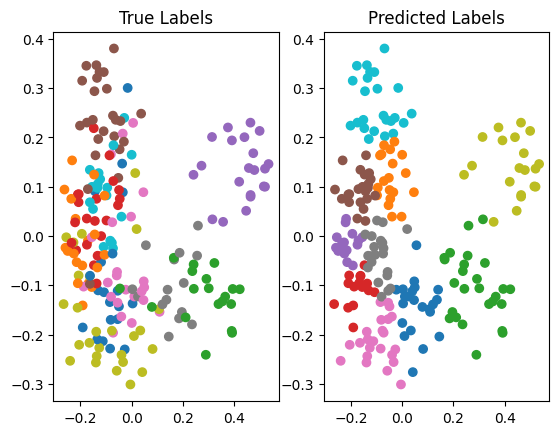

In [909]:
clusters = K_Means((features1), K)
predictions=get_predictions(clusters)
plot_features(data_pca, labels, predictions)

In [910]:
def show_cluster(cluster, flower_images):
    n=len(cluster)
    fig, ax = plt.subplots((n-1)//6+1, 6, constrained_layout=True)
    ax=ax.flatten()
    for i,image in enumerate(cluster):
        ax[i].imshow(normal_images[image])
        ax[i].set_xticks([])
        ax[i].set_yticks([])
    for i in range(len(cluster),np.prod(ax.shape)):
        ax[i].axis('off')

In [911]:
np.unique(predictions, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([22, 19, 26, 16, 16, 23, 23, 21, 20, 24]))

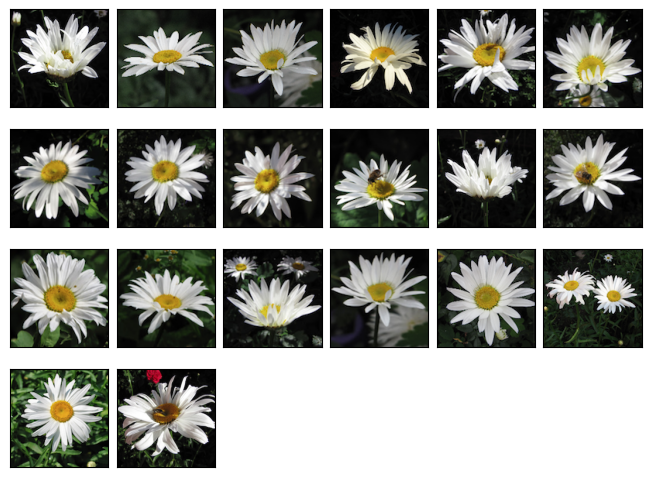

In [912]:
show_cluster(clusters[8], normal_images)

In [913]:
def plot_scores_for_different_k(max_k, labels, features):
    homogeneities_library = [0]*(max_k)
    homogeneities = [0]*(max_k)
    silhouettes_library = [0]*(max_k)
    silhouettes = [0]*(max_k)
    for i in range(2, max_k+2):
        model = KMeans(n_clusters=i, init="k-means++")
        predictions = model.fit_predict(features)
        homogeneity = homogeneity_score(labels, predictions)
        silhouette = silhouette_score(
            features, predictions, random_state=0)
        homogeneities_library[i-2] = homogeneity
        silhouettes_library[i-2] = silhouette
        clusters = K_Means(features, k=i)
        predictions = get_predictions(clusters)
        homogeneity = homogeneity_score(labels, predictions)
        silhouette = silhouette_score(
            features, predictions, random_state=0)
        homogeneities[i-2] = homogeneity
        silhouettes[i-2] = silhouette
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.plot(range(2, max_k+1),
             homogeneities_library[:-1], label='Homogeneity')
    plt.plot(range(2, max_k+1), silhouettes_library[:-1], label='Silhouette')
    plt.title("Scores for different k with kibrary")
    plt.xticks(np.arange(0, max_k+1, 5))
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(range(2, max_k+1),
             homogeneities[:-1], label='Homogeneity')
    plt.plot(range(2, max_k+1), silhouettes[:-1], label='Silhouette')
    plt.title("Scores for different k without kibrary")
    plt.xticks(np.arange(0, max_k+1, 5))
    plt.legend()

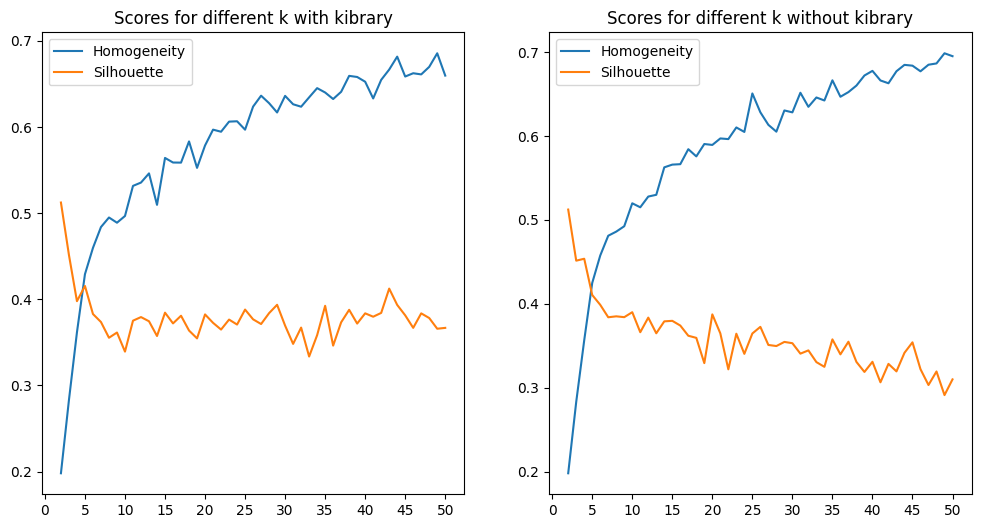

In [914]:
plot_scores_for_different_k(50, labels,features1)

In [915]:
def run_with_library(n_itter, features, labels,k):
    homogeneity = 0
    silhouette = 0
    for _ in range(n_itter):
        model=KMeans(n_clusters=k,init="k-means++")
        predictions = model.fit_predict(features)
        homogeneity += homogeneity_score(labels, predictions)
        silhouette += silhouette_score(features, predictions)
    return homogeneity/n_itter, silhouette/n_itter

In [916]:
print(run_with_library(10, features1, labels, K))
print(run_with_library(10, features2, labels, K))

(0.5060449553125885, 0.365789657831192)
(0.3035439722859785, 0.9210166871547699)


/home/babak/Codes/Python/lib/python3.11/site-packages/sklearn/base.py:1474: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


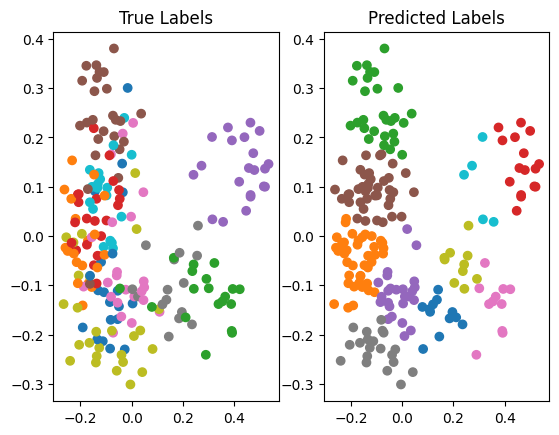

In [917]:
clusters = K_Means((features1), K)
predictions = get_predictions(clusters)
plot_features(data_pca, labels, predictions)

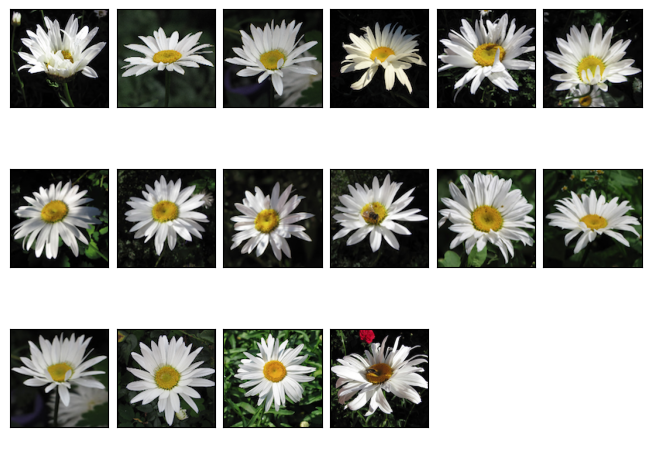

In [919]:
show_cluster(clusters[3], normal_images)

5. I chose 10 for k for two reasons:
    1. The given labels range from 0 to 9 so there are 10 species of flowers.
    2. By plotting the scores for different values of k we can see an elbow when k=10.

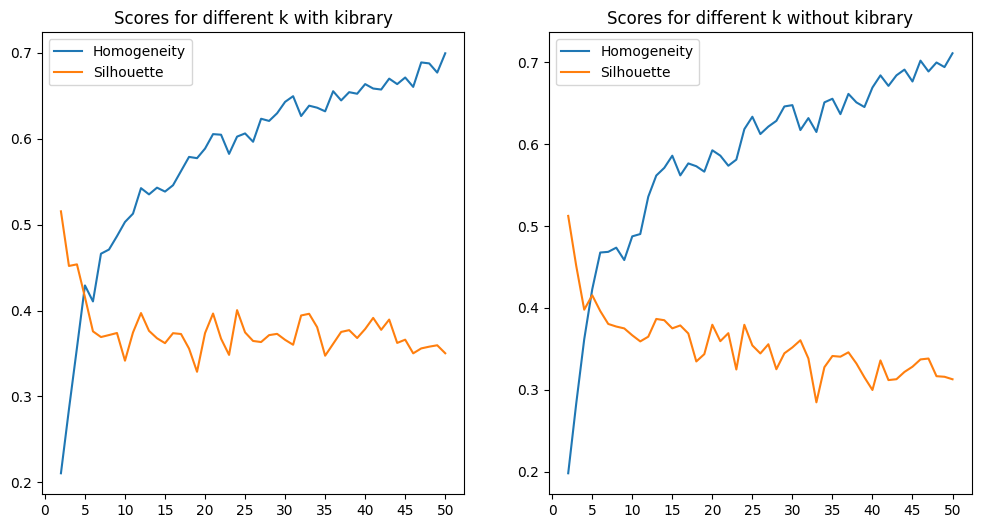

In [920]:
plot_scores_for_different_k(50, labels,features1)

## Using pixels as features

Let's see how the model works with pixels as features.

In [921]:
features3 = flower_images.reshape(features.shape[0], -1)
pca = PCA(n_components=2)
pca.fit(features3)
data_pca_pixels = pca.transform(features3)
pca = PCA(n_components=2)
pca.fit(features3)
features3 = pca.transform(features3)

In [922]:
run_without_library(10, features3, labels,K)

(0.34692805500283824, 0.35834612250328063)

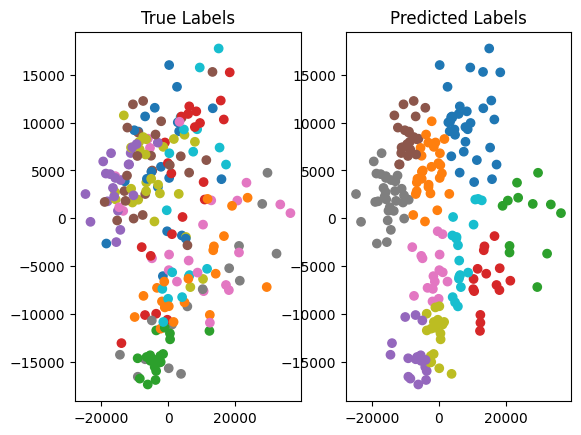

In [923]:
clusters = K_Means((features3), K)
predictions = get_predictions(clusters)
plot_features(data_pca_pixels, labels, predictions)

In [924]:
run_with_library(10, features3, labels,K)

(0.33227107103218434, 0.3670297473669052)

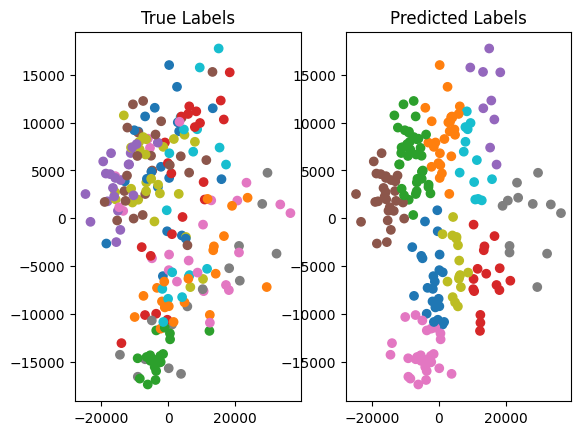

In [925]:
model=KMeans(n_clusters=K,init="k-means++")
predictions = model.fit_predict(features3)
plot_features(data_pca_pixels, labels, predictions)

# DBSCAN

In [926]:
def DB_SCAN(features, epsilon, min_pts):
    points=[(i,feature) for i,feature in enumerate(features)]
    np.random.shuffle(points)
    predictions=dict()
    clusters_i = []
    for k,new_core_point in points:
        if k in predictions:
            continue
        points_in_cluster = [k]
        for j, core_point in enumerate(points_in_cluster):
            number_of_points=min_pts
            new_points=[]
            for i, border_point in points:
                if i==k:
                    continue
                distance = np.linalg.norm(border_point-features[core_point])
                if distance<=epsilon and (i not in predictions or predictions[i]==len(clusters_i)-1):
                    number_of_points-=1
                    if i not in predictions:
                        new_points.append(i)
            if number_of_points<=0:
                points_in_cluster.extend(new_points)
                for i in new_points:
                    predictions[i]=len(clusters_i)-1
        clusters_i.append(points_in_cluster)
    return clusters_i

In [927]:
def find_best_parameters_DBSCAN(features, labels, min_eps, max_eps, steps,max_pts, with_library):
    best_score = 0
    best_eps = 0
    best_min_samples = 0
    eps=min_eps
    while eps<max_eps+steps:
        for min_samples in range(1, max_pts+1):
            if with_library:
                db = DBSCAN(eps=eps, min_samples=min_samples)
                predictions = db.fit_predict(features)
            else:
                clusters = DB_SCAN(features, epsilon=eps, min_pts=min_samples)
                predictions = get_predictions(clusters)
            if len(np.unique(predictions)) == 1 or len(np.unique(predictions))==2 or len(np.unique(predictions)) > 20:
                continue
            homogeneity = homogeneity_score(labels, predictions)
            try:
                silhouette = silhouette_score(features, predictions)
            except Exception:
                continue
            score = homogeneity*silhouette
            if score > best_score:
                best_score = score
                best_eps = eps
                best_min_samples = min_samples
        eps+=steps
    return best_eps, best_min_samples

In [928]:
eps,min_pts=find_best_parameters_DBSCAN(features1, labels, 0.01, 0.1,0.01,10,False)

In [929]:
clusters = DB_SCAN(features1, epsilon=eps, min_pts=min_pts)
predictions = get_predictions(clusters)
np.unique(predictions, return_counts=True)

(array([0, 1, 2]), array([190,  19,   1]))

In [930]:
print(homogeneity_score(labels, predictions),)
print(silhouette_score(features1, predictions))

0.12362819849938912
0.30811194


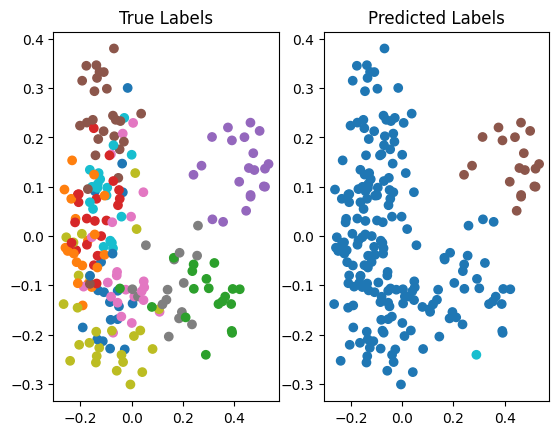

In [931]:
plot_features(data_pca, labels, predictions)

In [932]:
eps,min_pts = find_best_parameters_DBSCAN(features1, labels, 0.01,1,0.001,10,True)

In [933]:
db = DBSCAN(eps=eps, min_samples=min_pts)
predictions = db.fit_predict(features1)
np.unique(predictions, return_counts=True)

(array([-1,  0,  1,  2]), array([ 11, 159,  25,  15]))

In [934]:
print(homogeneity_score(labels, predictions),)
print(silhouette_score(features1, predictions))

0.2529417788132055
0.3791121


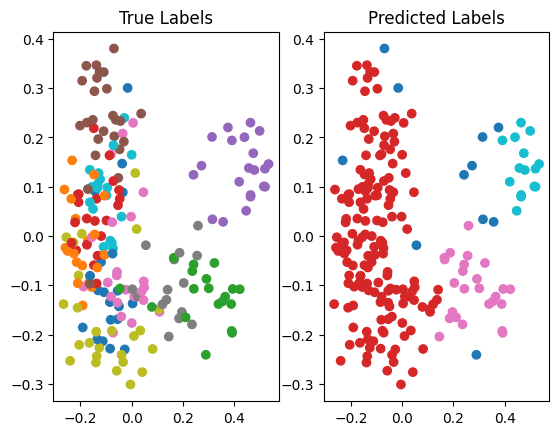

In [935]:
plot_features(data_pca, labels, predictions)

In [936]:
eps,min_pts = find_best_parameters_DBSCAN(features2, labels, 0.01, 0.1, 0.01,10,False)

In [937]:
clusters = DB_SCAN(features2, epsilon=eps, min_pts=min_pts)
predictions = get_predictions(clusters)
np.unique(predictions, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6]), array([33, 29, 92, 53,  1,  1,  1]))

In [938]:
print(homogeneity_score(labels, predictions),)
print(silhouette_score(features2, predictions))

0.28971421514518086
0.9856931


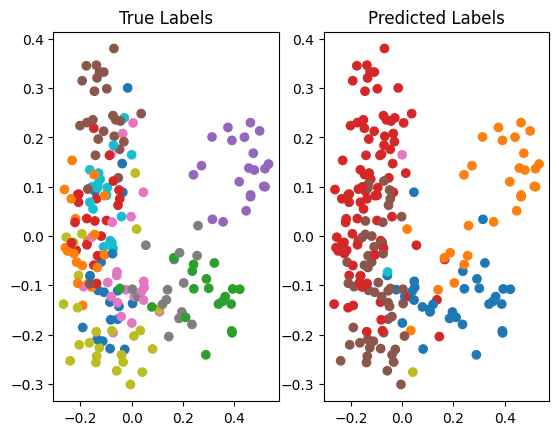

In [939]:
plot_features(data_pca, labels, predictions)

In [940]:
eps,min_pts = find_best_parameters_DBSCAN(features2, labels, 0.01, 1,0.01,10,True)

In [941]:
db = DBSCAN(eps=eps, min_samples=min_pts)
predictions = db.fit_predict(features2)
np.unique(predictions, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6]), array([53, 92, 33, 29,  1,  1,  1]))

In [942]:
print(homogeneity_score(labels, predictions),)
print(silhouette_score(features2, predictions))

0.2897142151451808
0.9856931


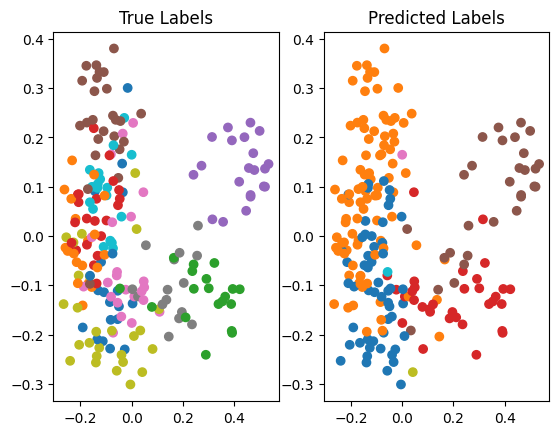

In [943]:
plot_features(data_pca, labels, predictions)

In [944]:
eps, min_pts = find_best_parameters_DBSCAN(features3, labels, 3000, 5000, 100,10,False)

In [945]:
clusters = DB_SCAN(features3, epsilon=4000, min_pts=min_pts)
predictions = get_predictions(clusters)
np.unique(predictions, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([200,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1]))

In [946]:
print(homogeneity_score(labels, predictions),)
print(silhouette_score(features3, predictions))

0.051484128227133094
-0.062027786


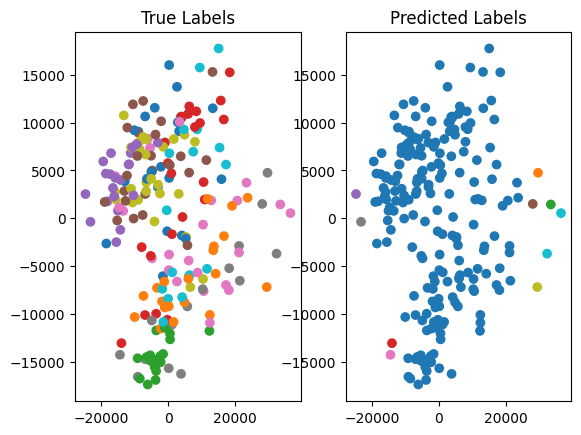

In [947]:
plot_features(data_pca_pixels, labels, predictions)

In [948]:
eps, min_pts = find_best_parameters_DBSCAN(features3, labels, 3000, 5000, 10, 10,True)

In [949]:
db = DBSCAN(eps=eps, min_samples=min_pts)
predictions = db.fit_predict(features3)
np.unique(predictions, return_counts=True)

(array([-1,  0,  1]), array([ 45,  64, 101]))

In [950]:
print(homogeneity_score(labels, predictions),)
print(silhouette_score(features3, predictions))

0.1696224373733763
0.38063416


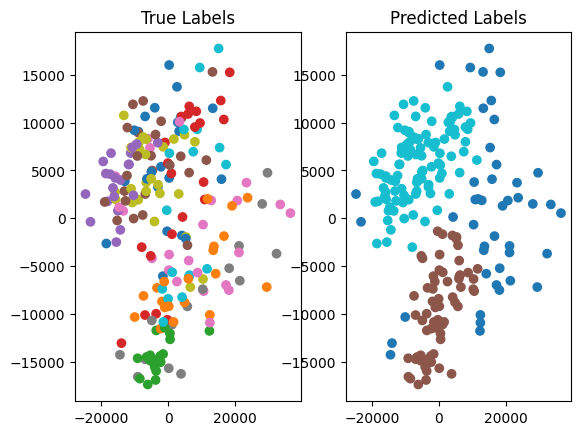

In [951]:
plot_features(data_pca_pixels, labels, predictions)

6. From the plotted pcas we can see how the two algorithms work. In the k means algorith the clusters are circular while in the dbscan algorithm the clusters are formed based on their density and there are some noise points left around clusters.  

7. Principal component analysis, or PCA, is a dimensionality reduction method that is often used to reduce the dimensionality of large data sets, by transforming a large set of variables into a smaller one that still contains most of the information in the large set.\
Principal components are new variables that are constructed as linear combinations or mixtures of the initial variables. These combinations are done in such a way that the new variables (i.e., principal components) are uncorrelated and most of the information within the initial variables is squeezed or compressed into the first components. So, the idea is 10-dimensional data gives you 10 principal components, but PCA tries to put maximum possible information in the first component, then maximum remaining information in the second and so on.\
Geometrically speaking, principal components represent the directions of the data that explain a maximal amount of variance, that is to say, the lines that capture most information of the data. The relationship between variance and information here, is that, the larger the variance carried by a line, the larger the dispersion of the data points along it, and the larger the dispersion along a line, the more information it has. To put all this simply, just think of principal components as new axes that provide the best angle to see and evaluate the data, so that the differences between the observations are better visible.

8.
    **Homogeneity** metric of a cluster labeling given a ground truth.A clustering result satisfies homogeneity if all of its clusters contain only data points which are members of a single class.This metric is independent of the absolute values of the labels: a permutation of the class or cluster label values won’t change the score value in any way.\
    When all samples in cluster **k** have the same label **c**, the homogeneity equals 1.
    $$H(C|K)=-\sum_{C,K}^{}\frac{n_{ck}}{N}log(\frac{n_{ck}}{n_{k}})$$
    $$Homogeneity Score=1-\frac{H(C|K)}{H(C)}$$
    The **silhouette** value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. If most objects have a high value, then the clustering configuration is appropriate. If many points have a low or negative value, then the clustering configuration may have too many or too few clusters. A clustering with an average silhouette width of over 0.7 is considered to be "strong", a value over 0.5 "reasonable" and over 0.25 "weak", but with increasing dimensionality of the data, it becomes difficult to achieve such high values because of the curse of dimensionality, as the distances become more similar. The silhouette score is specialized for measuring cluster quality when the clusters are convex-shaped, and may not perform well if the data clusters have irregular shapes or are of varying sizes.
    $$Silhouette Score(i)=\frac{max(a_{i},b_{i})}{b_{i}-a_{i}}$$
    $$Silhouette Score=\frac{\sum_{i=1}^{n}Silhouette Score(i)}{n}$$

9. It really depends on the features and the preprocess functions we perform on images though, with the three features I tested I get better results for the first and third features and that may be due to not having a number of separated dense regions in the features so the dbscan algorithm would make the most of the images in the dense region in middle a cluster.

10. By changing the data preprocessing method, feature extraction method, clustering algorithm selection algorithm, parameter tuning, using differrent evaluation metrics and iterative refinement.

# References

https://en.wikipedia.org/wiki/Silhouette_(clustering)\
https://en.wikipedia.org/wiki/Curse_of_dimensionality\
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.homogeneity_score.html\
https://builtin.com/data-science/step-step-explanation-principal-component-analysis\
https://www.geeksforgeeks.org/difference-between-k-means-and-dbscan-clustering\
https://medium.com/@mohitjavali/10-ways-to-extract-features-from-an-image-f44c8e9b0fbf\
https://www.linkedin.com/advice/0/what-some-ways-improve-accuracy-your-k-means-clustering-har9f